# 对原加密算法抵抗已知明文攻击的分析

原加密算法使用了两个混沌序列, 其中一个为用于对每一个分块中的像素进行加密, 另一个用于对分块进行块置乱, 这里就出现了显著的弱点

1. 当攻击者已知用户加密前的图片时, 根据每个分块中相邻像素差值在加密前后不变的特性, 可以较为容易地确定块置乱时使用的映射
2. 确定块置乱时使用的映射后, 我们便可以唯一确定每个块中每个像素与哪一个数进行了XOR运算, 进而可以反推用于对每一个分块像素进行加密的混沌序列
3. 经过以上两步, 攻击者便可以找到加密前后的图像的变换关系(块置乱的变换关系 & 像素XOR的变换关系), 通过这个关系便可以攻击其他的加密后的图像

# 针对原加密算法抗已知明文攻击能力弱的改进

## 解决方向

攻击者能够使用发起已知明文攻击的原因是:
1. 使用相同的密钥生成的混沌序列内容相同, 因此使用相同密钥加密的图片具有相同的映射关系
2. 密文域图像保留了原图像的局部相关性, 因此可以根据该信息反推变换关系

解决方向: 使用消息认证码(MAC)基于图像与密钥生成混沌序列
1. 若每一副图片的的混沌序列均不同, 那么即使攻击者通过已知明文攻击获得了一幅图片的加密变换关系, 那么其也不能使用该变换关系攻击其他的加密图像


## 难点

目的: 在加密与解密过程中使用消息认证码(MAC)生成相同的混沌序列

要求:
- 保证加密与解密时 MAC 输入的密钥与消息完全相同
- 消息需要由图片生成, 且可以从图片的明文域与密文域生成同样的消息

其中, 密钥可以由加密与解密的用户保管, 因此可以保证加密与解密时密钥相同, 主要的难点在于从图片明文域与密文域生成相同的消息

我们可以从在加密过程中保留的消息入手

1. 加密过程中保留了局部像素之间的关系
    - 一个分块中的像素分为两种, 一种为参考像素, 一种为用于信息嵌入的像素
        - 信息嵌入像素在嵌入信息后像素的值无论是明文域还是密文域都发生了一些变化, 因此从这些像素中提取信息较为困难
        - 参考像素在信息嵌入过程中不会发生变化, 因此可以从此处入手
2. 在块置乱的过程中, 虽然块的顺序被打乱, 但是若为每个块生成一个可排序的标识符, 对该标识符排序后的序列依然保持不变
    - 结合 1 中的分析, 我们可以将每一个分块中的参考像素作为标识符, 但是这依然具有一些问题:
        1. 虽然参考像素在信息嵌入前后不会变化, 但是在该像素在进行 XOR 加密前后依然不同
        2. XOR 加密前后的像素相关系较小, 难以利用

## 目前改进方案

结合以上分析, 目前我的改进方案如下
- 加密
    1. 仅使用加密密钥生成用于 XOR 加密的混沌序列
    2. 使用该序列对块置乱前的每一个子块进行 XOR 加密
    3. 提取每一个子块中加密后参考像素的像素值
    4. 对上一步提取的像素值进行排序
    5. 将上一步排序后的像素值作为 MAC 函数输入的消息, 将加密密钥作为 MAC 函数输入的密钥
    6. 使用 MAC 函数输出的消息认证码生成用于块置乱的混沌序列
    7. 使用上一步生成的混沌序列进行块置乱
- 解密
    1. 提取每一个子块中加密后参考像素的像素值
    2. 对上一步提取的像素值进行排序
    3. 将上一步排序后的像素值作为 MAC 函数输入的消息, 将解密密钥作为 MAC 函数输入的密钥
    4. 使用 MAC 函数输出的消息认证码生成用于块逆置乱的混沌序列
    5. 使用上一步生成的混沌序列对块置乱进行恢复
    6. 仅使用加密密钥生成用于 XOR 加密的混沌序列
    7. 使用上一步生成的混沌序列对每一个子块进行 XOR 解密

# 实现

## 消息认证码(MAC)测试

In [ ]:
imatlab_export_fig('print-png'); % Static png figures.(10 KB) (尺寸最小)

In [19]:
mac = pkg.utils.Mac('HmacSHA256', '1234')


mac = 

  Mac - 属性:

    algorithm: 'HmacSHA256'
          key: [1x1 javax.crypto.spec.SecretKeySpec]
     instance: [1x1 javax.crypto.Mac]
       output: []
       length: 32



In [20]:
[outputByte, outputStr] = mac.doFinal('1234')


outputByte =

  32x1 uint8 列向量

    78
    79
   234
   234
   149
   157
    66
    97
    85
   164
   128
   220
     7
   239
   146
   244
   117
    78
   233
    62
   219
   229
   109
   153
    61
   116
   241
    49
    73
   126
   102
   251


outputStr = 

    "4E4FEAEA959D426155A480DC07EF92F4754EE93EDBE56D993D74F131497E66FB"



## 加密

In [45]:
passphrase = '123';

plainImage_0 = pkg.Image('.\images\Lena.tiff');
[cipherImage, pixel_0] = pkg.improve.cipher.encrypt(plainImage_0, passphrase);

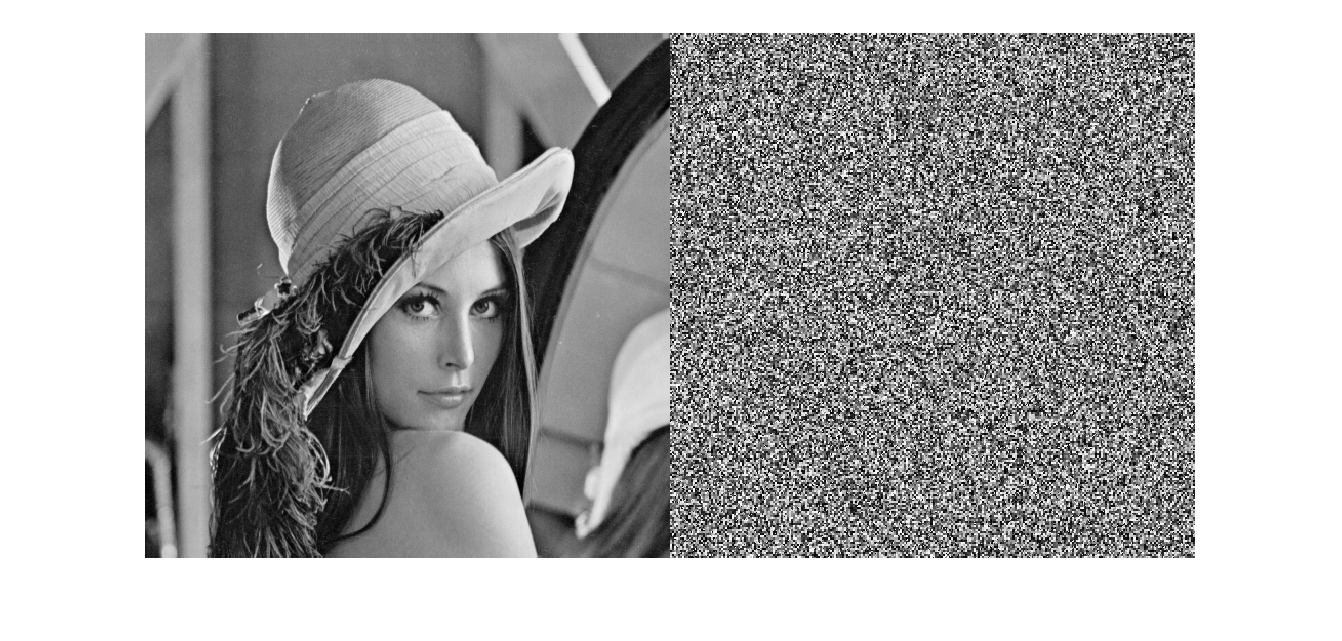

In [46]:
close all;
figure;
set(gcf, 'outerposition', [1 1 1080 540]); % 设置当前图窗大小
% set(gca, 'position', [60 40 1800 1000]); % 设置当前子图的位置
imshowpair(plainImage_0.gray_img, cipherImage.gray_img,'montage');  % 并列显示图像

## 解密

In [47]:
[plainImage_1, pixel_1] = pkg.improve.cipher.decrypt(cipherImage, passphrase);

In [48]:
length(pixel_0)
sum(pixel_0 ~= pixel_1, 'all')


ans =

       65536


ans =

     0



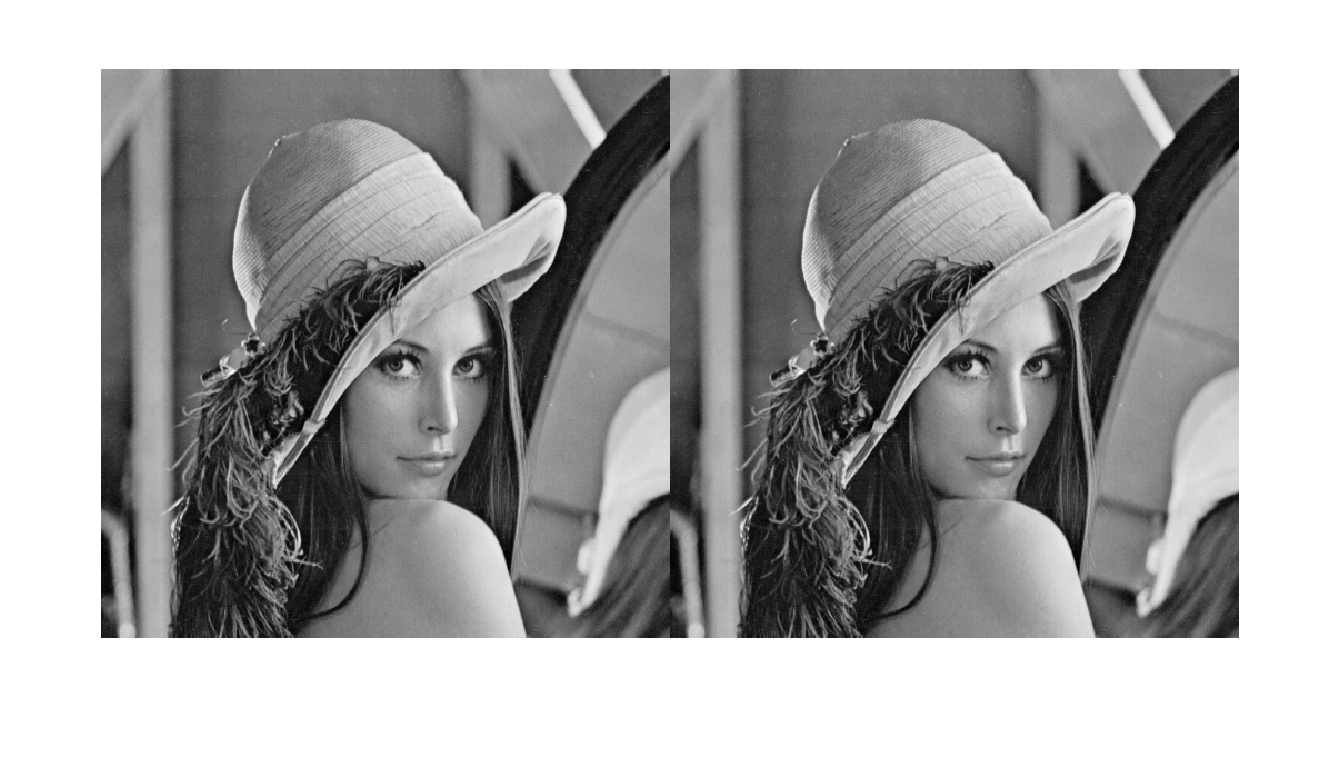

In [49]:
close all;
figure;
set(gcf, 'outerposition', [1 1 1080 640]); % 设置当前图窗大小
% set(gca, 'position', [60 40 1800 1000]); % 设置当前子图的位置
imshowpair(plainImage_0.gray_img, plainImage_1.gray_img,'montage');  % 并列显示图像

In [50]:
for index_i = 1:512
    for index_j = 1:512
        if plainImage_0.gray_img(index_i, index_j) ~= plainImage_1.gray_img(index_i, index_j)
            disp([index_i, index_j, plainImage_0.gray_img(index_i, index_j), plainImage_1.gray_img(index_i, index_j)]);
        end
    end
end

In [51]:
for index = 1:8
    sum(plainImage_0.bit_plane(:, :, index) ~= plainImage_1.bit_plane(:, :, index), 'all')
end


ans =

     0


ans =

     0


ans =

     0


ans =

     0


ans =

     0


ans =

     0


ans =

     0


ans =

     0

